Data loaded and polar transformation complete.


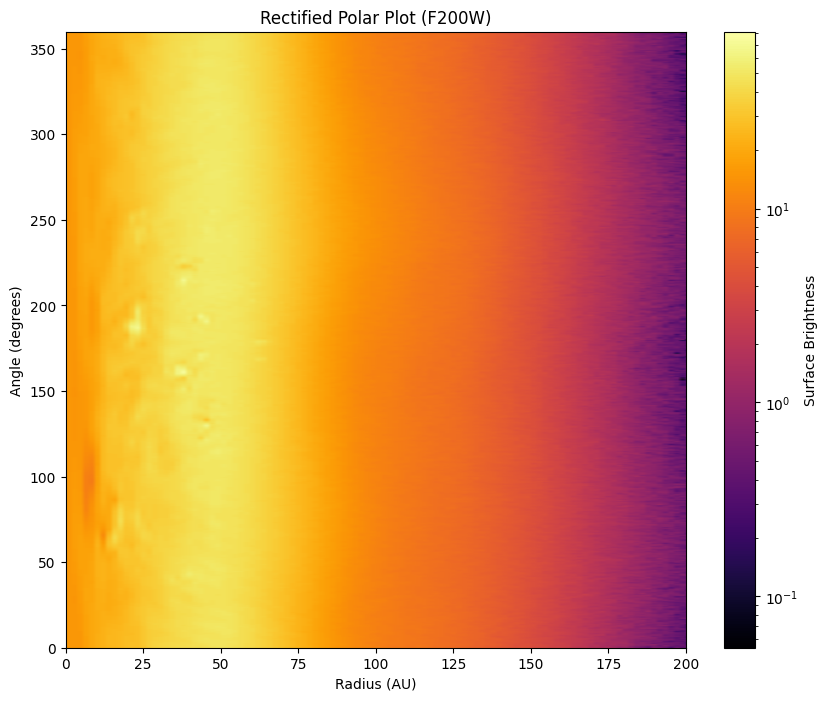

In [27]:
# Rectified Polar Plot
# Read fits file at source/F200W.fits
# Plot the data in a rectified polar plot

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from scipy.ndimage import map_coordinates

# Load the FITS file
fits_file = 'source/F200W.fits'
hdul = fits.open(fits_file)
data = hdul[0].data
image = data[:,:,1]

# Read header
header = hdul[0].header
# print(header) # You can uncomment this to see the header details
pixel_scale = header['PIXSCALE'] # in arcsec/pixel
dist = 60.1 # distance to TW Hya in pc

# Calculate color limits for this specific image
clim_low_raw, clim_high_raw = np.array([0.001, 1.5]) * np.nanpercentile(image, 99.975)

# --- Polar transform ---

# Image dimensions and center
ny, nx = image.shape
center_y, center_x = (ny - 1) / 2.0, (nx - 1) / 2.0

# Define the polar grid
# The radius is the distance from the center to the corner.
max_radius_pix = np.sqrt(center_y**2 + center_x**2)
nr = int(max_radius_pix)
ntheta = 720 # number of angular points

radii_pix = np.linspace(0, max_radius_pix, nr)
thetas = np.linspace(0, 2 * np.pi, ntheta)

# Create a grid of polar coordinates
r_grid, theta_grid = np.meshgrid(radii_pix, thetas)

# Convert polar to Cartesian coordinates
x_cart = r_grid * np.cos(theta_grid + np.pi/2) + center_x
y_cart = r_grid * np.sin(theta_grid + np.pi/2) + center_y

# The coordinates for map_coordinates should be in a (2, N) array
coords = np.array([y_cart.ravel(), x_cart.ravel()])

# Perform the transformation
polar_image = map_coordinates(image, coords, order=1, mode='constant', cval=np.nan).reshape((ntheta, nr))
print("Data loaded and polar transformation complete.")

# plot the image
plt.figure(figsize=(10, 8), dpi=100)
plt.imshow(polar_image, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=clim_low_raw, vmax=clim_high_raw),
           aspect='auto', extent=[0, max_radius_pix*pixel_scale*dist, 0, 360])

# Set x limit to 0 to 200 AU
plt.xlim(0, 200)
plt.colorbar(label='Surface Brightness')
filter_name = fits_file.split('/')[-1].split('.')[0]
plt.title(f'Rectified Polar Plot ({filter_name})')
plt.ylabel('Angle (degrees)')
plt.xlabel('Radius (AU)')
plt.savefig('rectified_polar.png')
plt.show()

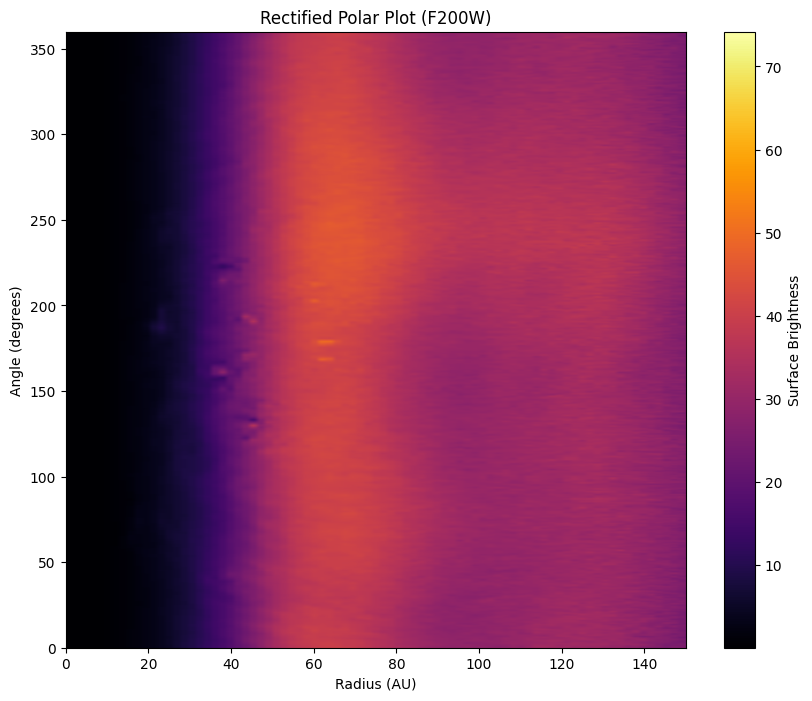

In [32]:
# --- Diagnostic: Check Radial Brightness Profile ---
# Apply R^2 scaling to enhance outer features
radii_arcsec = radii_pix * pixel_scale
polar_image_r2_scaled = np.zeros_like(polar_image)
for i in range(polar_image.shape[1]):
    if radii_arcsec[i] > 0:
        polar_image_r2_scaled[:, i] = polar_image[:, i] * (radii_arcsec[i]**2)

# Calculate color limits for this specific image
clim_low_raw, clim_high_raw = np.array([0.001, 1.5]) * np.nanpercentile(polar_image_r2_scaled, 100)

# plot the image
plt.figure(figsize=(10, 8), dpi=100)
plt.imshow(polar_image_r2_scaled, origin='lower', cmap='inferno', 
           vmin=clim_low_raw, vmax=clim_high_raw,
           aspect='auto', extent=[0, max_radius_pix*pixel_scale*dist, 0, 360])

# Set x limit to 0 to 200 AU
plt.xlim(0, 150)
plt.colorbar(label='Surface Brightness')
filter_name = fits_file.split('/')[-1].split('.')[0]
plt.title(f'Rectified Polar Plot ({filter_name})')
plt.ylabel('Angle (degrees)')
plt.xlabel('Radius (AU)')
plt.savefig('rectified_polar.png')
plt.show()

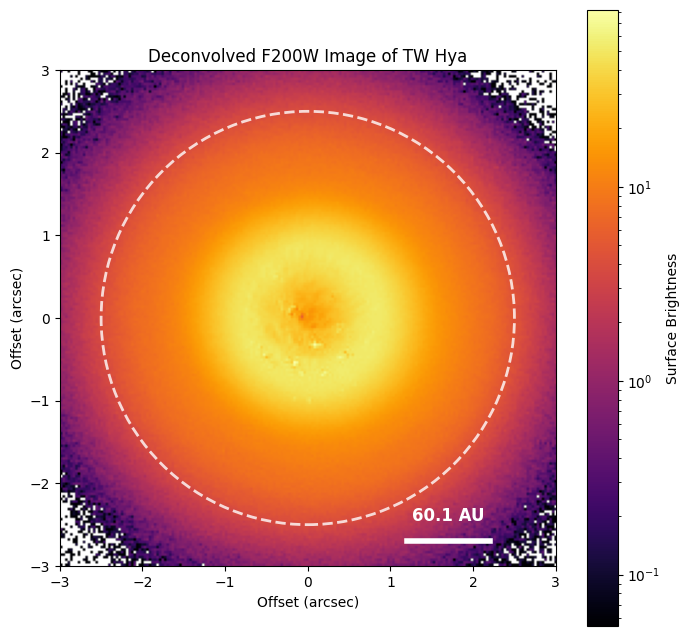

In [2]:
# --- Plot Original Image ---
plt.figure(figsize=(8, 8), dpi=100)

# Calculate extent in arcseconds centered on the image
extent_arcsec = 6.0  # 5 arcsecond scope
half_extent = extent_arcsec / 2
extent = [-half_extent, half_extent, -half_extent, half_extent]

# Calculate the pixel range corresponding to 5 arcseconds
extent_pixels = extent_arcsec / pixel_scale
half_extent_pix = extent_pixels / 2

# Create a cropped view centered on the image
x_start = int(center_x - half_extent_pix)
x_end = int(center_x + half_extent_pix)
y_start = int(center_y - half_extent_pix)
y_end = int(center_y + half_extent_pix)

# Ensure we don't go outside image bounds
x_start = max(0, x_start)
x_end = min(nx, x_end)
y_start = max(0, y_start)
y_end = min(ny, y_end)

cropped_image = image[y_start:y_end, x_start:x_end]

plt.imshow(cropped_image, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=clim_low_raw, vmax=clim_high_raw),
           extent=extent)

# Add reference circle at 5" radius (actually 2.5" radius since extent goes from -2.5 to +2.5)
circle = plt.Circle((0, 0), 2.5, fill=False, color='white', linewidth=2, linestyle='--', alpha=0.8)
plt.gca().add_patch(circle)

# Add 3" scale bar in the bottom right corner
bar_length = 1.0  # 1 arcsecond
bar_x_start = half_extent - 0.8  # Position near right edge
bar_x_end = bar_x_start - bar_length
bar_y = -half_extent + 0.3  # Position near bottom edge

plt.plot([bar_x_end, bar_x_start], [bar_y, bar_y], 'white', linewidth=4)
plt.text(bar_x_start - bar_length/2, bar_y + 0.2, f'{bar_length*dist} AU', color='white', 
         ha='center', va='bottom', fontsize=12, fontweight='bold')

# Convert extent to AU for secondary labels
extent_au = np.array(extent) * dist  # Convert arcsec to AU

plt.colorbar(label='Surface Brightness')
plt.title(f'Deconvolved {filter_name} Image of TW Hya')

# Set primary axes labels in arcseconds
plt.xlabel('Offset (arcsec)')
plt.ylabel('Offset (arcsec)')

plt.savefig('original_image.png', dpi=300, bbox_inches='tight')
plt.show()


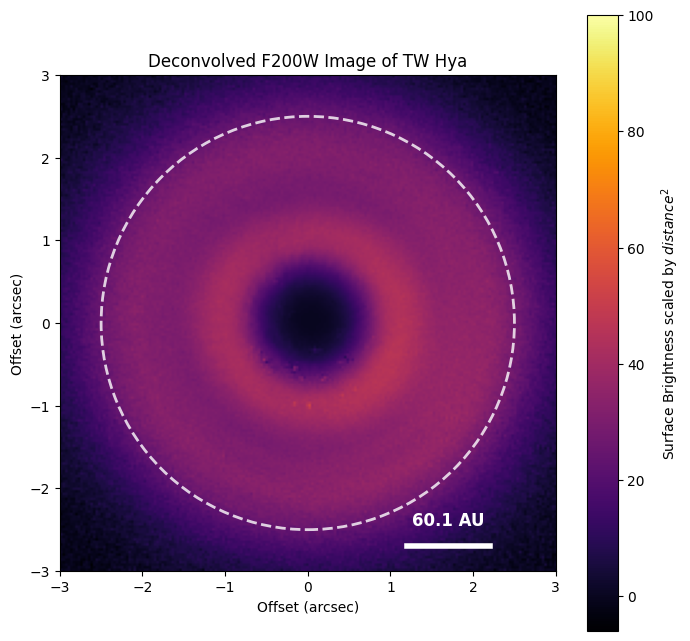

In [3]:
# --- Plot Original Image ---
plt.figure(figsize=(8, 8), dpi=100)

# Calculate extent in arcseconds centered on the image
extent_arcsec = 6.0  # 5 arcsecond scope
half_extent = extent_arcsec / 2
extent = [-half_extent, half_extent, -half_extent, half_extent]

# Calculate the pixel range corresponding to 5 arcseconds
extent_pixels = extent_arcsec / pixel_scale
half_extent_pix = extent_pixels / 2

# Create a cropped view centered on the image
x_start = int(center_x - half_extent_pix)
x_end = int(center_x + half_extent_pix)
y_start = int(center_y - half_extent_pix)
y_end = int(center_y + half_extent_pix)

# Ensure we don't go outside image bounds
x_start = max(0, x_start)
x_end = min(nx, x_end)
y_start = max(0, y_start)
y_end = min(ny, y_end)

cropped_image = image[y_start:y_end, x_start:x_end]

# distance of each pixel in arcseconds
distances = np.empty_like(cropped_image)
for i in range(cropped_image.shape[0]):
    for j in range(cropped_image.shape[1]):
        # Calculate distance from the center in arcseconds
        distances[i, j] = np.sqrt(((y_start + i) - center_y)**2 + ((x_start + j) - center_x)**2) * pixel_scale

plt.imshow(cropped_image*distances**2, origin='lower', cmap='inferno', 
           vmax=100,
           extent=extent)

# Add reference circle at 5" radius (actually 2.5" radius since extent goes from -2.5 to +2.5)
circle = plt.Circle((0, 0), 2.5, fill=False, color='white', linewidth=2, linestyle='--', alpha=0.8)
plt.gca().add_patch(circle)

# Add 3" scale bar in the bottom right corner
bar_length = 1.0  # 1 arcsecond
bar_x_start = half_extent - 0.8  # Position near right edge
bar_x_end = bar_x_start - bar_length
bar_y = -half_extent + 0.3  # Position near bottom edge

plt.plot([bar_x_end, bar_x_start], [bar_y, bar_y], 'white', linewidth=4)
plt.text(bar_x_start - bar_length/2, bar_y + 0.2, f'{bar_length*dist} AU', color='white', 
         ha='center', va='bottom', fontsize=12, fontweight='bold')

# Convert extent to AU for secondary labels
extent_au = np.array(extent) * dist  # Convert arcsec to AU

plt.colorbar(label=r'Surface Brightness scaled by $distance^2$')
plt.title(f'Deconvolved {filter_name} Image of TW Hya')

# Set primary axes labels in arcseconds
plt.xlabel('Offset (arcsec)')
plt.ylabel('Offset (arcsec)')

plt.savefig('original_image.png', dpi=300, bbox_inches='tight')
plt.show()

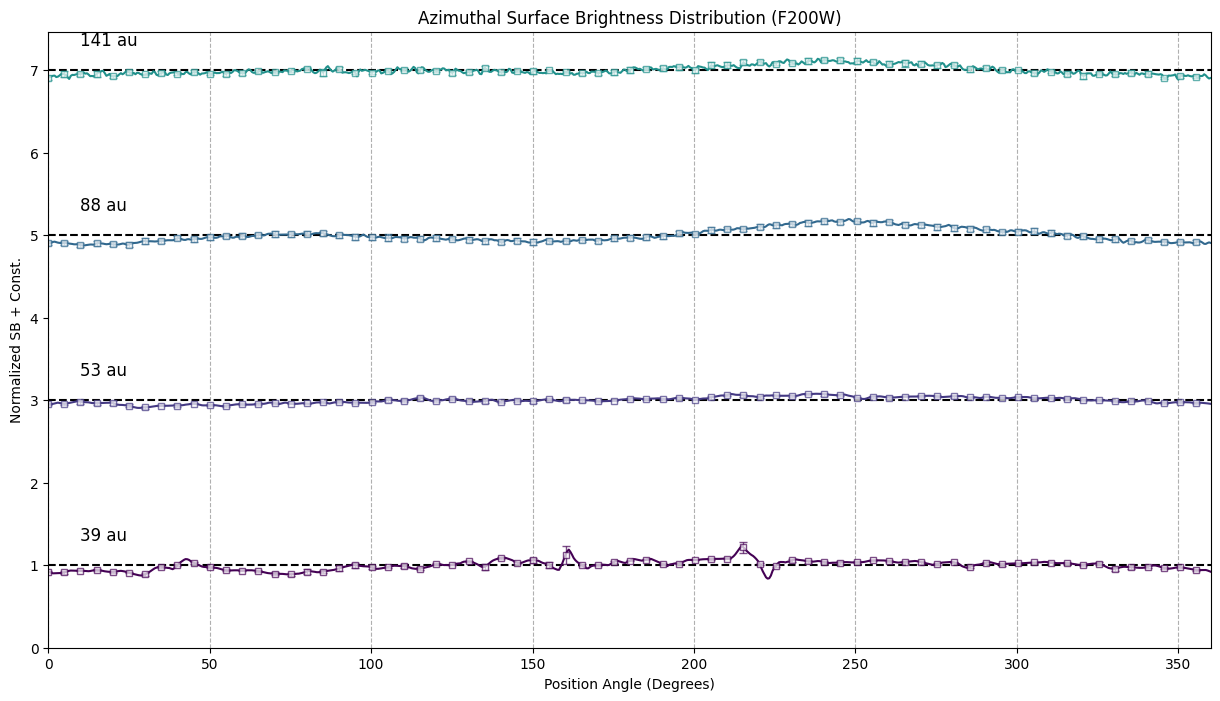

In [4]:
# --- Plot Azimuthal Surface Brightness Distribution ---

# Radii of interest in au
radii_au = np.array([39, 53, 88, 141])

# Convert au to pixels
radii_pix_interest = (radii_au / dist) / pixel_scale

# Find the closest index in our radii_pix array
radii_indices = [np.argmin(np.abs(radii_pix - r)) for r in radii_pix_interest]

# Angles in degrees
angles_deg = np.rad2deg(thetas)

plt.figure(figsize=(15, 8), dpi=100)

# Define the width of the annulus for averaging (in pixels)
annulus_width = 3 # e.g., +/- 1 pixel from the center radius, total 3 pixels
annulus_half_width = annulus_width // 2

# Create a list of colors for the plots
colors = plt.cm.viridis(np.linspace(0, 0.5, len(radii_au)))

# Plot each profile
for i, (radius_au, radius_idx) in enumerate(zip(radii_au, radii_indices)):
    # Extract the brightness profile over an annulus
    start_idx = max(0, radius_idx - annulus_half_width)
    end_idx = min(polar_image.shape[1], radius_idx + annulus_half_width + 1)
    
    annulus_data = polar_image[:, start_idx:end_idx]
    
    # Calculate the mean profile and standard deviation along the annulus
    profile = np.nanmean(annulus_data, axis=1)
    std_dev = np.nanstd(annulus_data, axis=1)
    
    # Number of pixels in the radial direction for the error calculation
    pixel_number = annulus_data.shape[1]
    if pixel_number == 0: # Avoid division by zero if annulus is empty
        continue

    # Calculate the error
    yerr = std_dev / np.sqrt(pixel_number)
    
    # Normalize the profile and error
    profile_mean = np.nanmean(profile)
    if np.isnan(profile_mean) or profile_mean == 0: # Avoid division by zero or nan
        continue

    # Add offset to separate the plots
    offset = i*2
    
    normalized_profile = profile / profile_mean + offset
    normalized_yerr = yerr / profile_mean
    
    # Define a stride to reduce the number of points for error bars
    stride = 10 # Plot one point every 10 degrees

    # Get the color for the current line
    color = colors[i]

    # Add dashed line at the mean level
    plt.axhline(y=offset + 1, linestyle='--', color='black')

    # Plot with error bars (open squares)
    plt.errorbar(angles_deg[::stride], normalized_profile[::stride], yerr=normalized_yerr[::stride], fmt='s', markersize=5, capsize=3, ecolor=color, elinewidth=1, markeredgecolor=color, markerfacecolor='white', alpha=0.7)
    
    # Overplot the line
    plt.plot(angles_deg, normalized_profile, '-', color=color)
    
    # Add text annotation for the radius
    plt.text(10, offset + 1.3, f'{radius_au} au', fontsize=12)
    
plt.title(f'Azimuthal Surface Brightness Distribution ({filter_name})')
plt.xlabel('Position Angle (Degrees)')
plt.ylabel('Normalized SB + Const.')
plt.xlim(0, 360)
plt.grid(axis='x', linestyle='--')

# Adjust y-axis to match example
plt.ylim(bottom=0)

plt.savefig('azimuthal_distribution.png')
plt.show()


/var/folders/1j/zshfrbrd0ng3c307tp6j8r2r0000gn/T/ipykernel_57202/3709331621.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


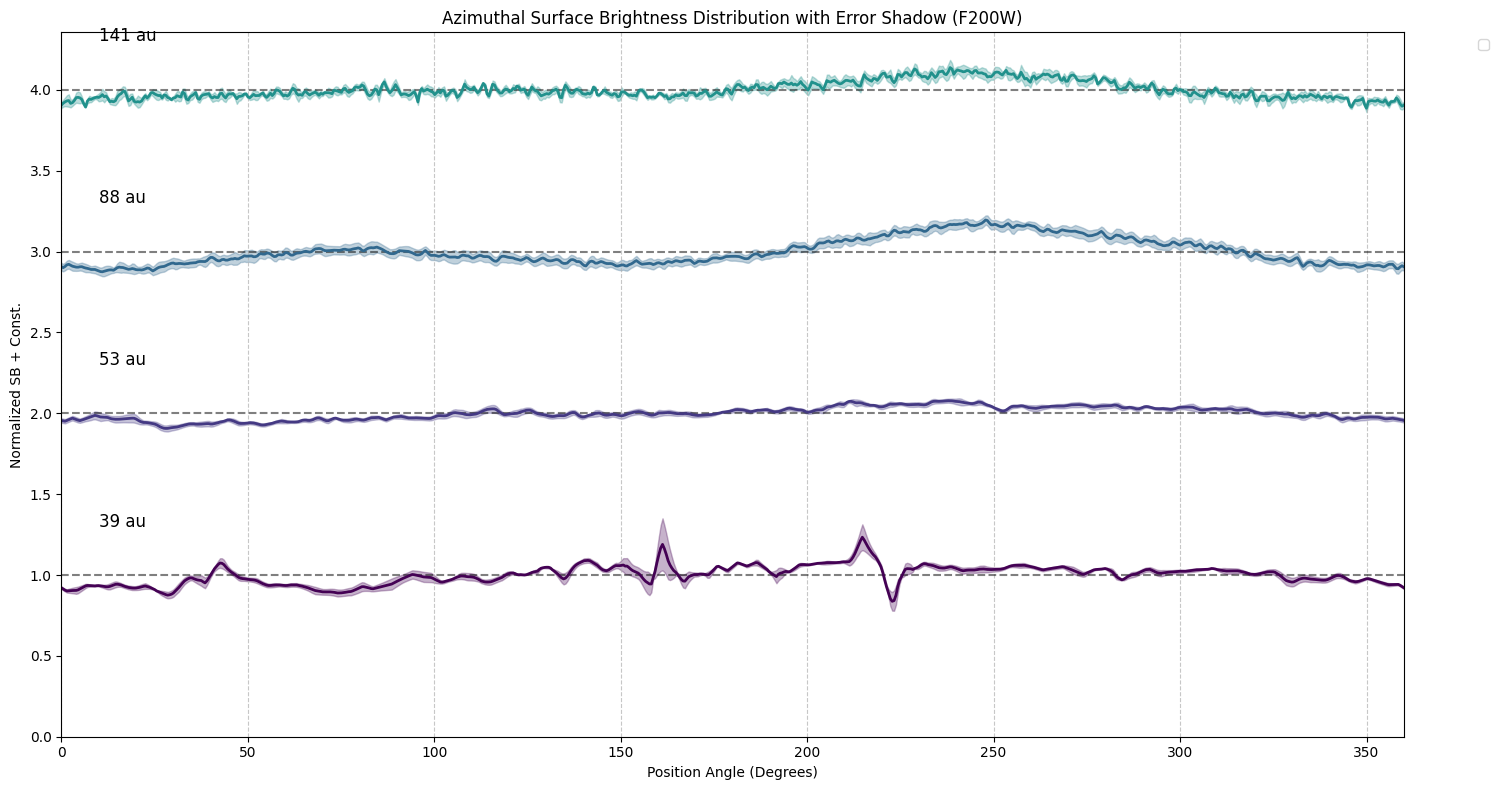

In [5]:
# --- Plot Azimuthal Surface Brightness Distribution with Shadow Error ---

# Radii of interest in au
radii_au = np.array([39, 53, 88, 141])

# Convert au to pixels
radii_pix_interest = (radii_au / dist) / pixel_scale

# Find the closest index in our radii_pix array
radii_indices = [np.argmin(np.abs(radii_pix - r)) for r in radii_pix_interest]

# Angles in degrees
angles_deg = np.rad2deg(thetas)

plt.figure(figsize=(15, 8), dpi=100)

# Define the width of the annulus for averaging (in pixels)
annulus_width = 3 # e.g., +/- 1 pixel from the center radius, total 3 pixels
annulus_half_width = annulus_width // 2

# Create a list of colors for the plots
colors = plt.cm.viridis(np.linspace(0, 0.5, len(radii_au)))

# Plot each profile
for i, (radius_au, radius_idx) in enumerate(zip(radii_au, radii_indices)):
    # Extract the brightness profile over an annulus
    start_idx = max(0, radius_idx - annulus_half_width)
    end_idx = min(polar_image.shape[1], radius_idx + annulus_half_width + 1)
    
    annulus_data = polar_image[:, start_idx:end_idx]
    
    # Calculate the mean profile and standard deviation along the annulus
    profile = np.nanmean(annulus_data, axis=1)
    std_dev = np.nanstd(annulus_data, axis=1)
    
    # Number of pixels in the radial direction for the error calculation
    pixel_number = annulus_data.shape[1]
    if pixel_number == 0: # Avoid division by zero if annulus is empty
        continue

    # Calculate the error
    yerr = std_dev / np.sqrt(pixel_number)
    
    # Normalize the profile and error
    profile_mean = np.nanmean(profile)
    if np.isnan(profile_mean) or profile_mean == 0: # Avoid division by zero or nan
        continue

    # Add offset to separate the plots
    offset = i
    
    normalized_profile = profile / profile_mean + offset
    normalized_yerr = yerr / profile_mean
    
    # Get the color for the current line
    color = colors[i]

    # Add dashed line at the mean level
    plt.axhline(y=offset + 1, linestyle='--', color='black', alpha=0.5)
    
    # Calculate upper and lower bounds for the shadow
    upper_bound = normalized_profile + normalized_yerr
    lower_bound = normalized_profile - normalized_yerr
    
    # Plot the shaded error region (shadow)
    plt.fill_between(angles_deg, lower_bound, upper_bound, 
                     alpha=0.3, color=color)
    
    # Overplot the main line
    plt.plot(angles_deg, normalized_profile, '-', color=color, linewidth=2)
    
    # Add text annotation for the radius
    plt.text(10, offset + 1.3, f'{radius_au} au', fontsize=12, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.0))
    
plt.title(f'Azimuthal Surface Brightness Distribution with Error Shadow ({filter_name})')
plt.xlabel('Position Angle (Degrees)')
plt.ylabel('Normalized SB + Const.')
plt.xlim(0, 360)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust y-axis to match example
plt.ylim(bottom=0)

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('azimuthal_distribution_shadow.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/1j/zshfrbrd0ng3c307tp6j8r2r0000gn/T/ipykernel_57202/474972694.py:14: RuntimeWarning: Mean of empty slice
  radial_profile = np.nanmean(polar_image, axis=0)
/var/folders/1j/zshfrbrd0ng3c307tp6j8r2r0000gn/T/ipykernel_57202/474972694.py:15: RuntimeWarning: Mean of empty slice
  radial_profile_r2 = np.nanmean(polar_image_r2_scaled, axis=0)


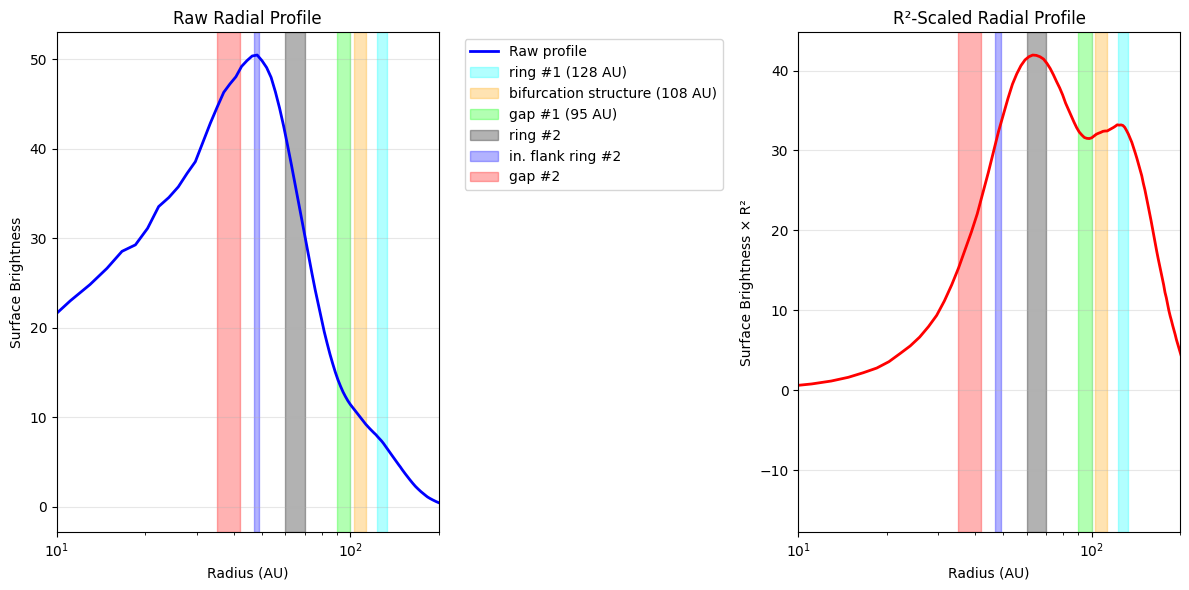


Numerical comparison of ring #1 vs gap #1:
ring #1 (128 AU) (123-133 AU):
  Raw mean: 7.30e+00
  R² mean: 3.29e+01
  Radius range in pixels: 66 to 72
bifurcation structure (108 AU) (103-113 AU):
  Raw mean: 9.96e+00
  R² mean: 3.23e+01
  Radius range in pixels: 56 to 61
gap #1 (95 AU) (90-100 AU):
  Raw mean: 1.27e+01
  R² mean: 3.17e+01
  Radius range in pixels: 49 to 54
ring #2 (60-70 AU):
  Raw mean: 3.61e+01
  R² mean: 4.16e+01
  Radius range in pixels: 32 to 38
in. flank ring #2 (47-49 AU):
  Raw mean: 5.04e+01
  R² mean: 3.11e+01
  Radius range in pixels: 25 to 26
gap #2 (35-42 AU):
  Raw mean: 4.71e+01
  R² mean: 1.99e+01
  Radius range in pixels: 19 to 23


In [33]:
# --- Diagnostic: Check Radial Brightness Profile ---
# Apply R^2 scaling to enhance outer features
radii_arcsec = radii_pix * pixel_scale
polar_image_r2_scaled = np.zeros_like(polar_image)
for i in range(polar_image.shape[1]):
    if radii_arcsec[i] > 0:
        polar_image_r2_scaled[:, i] = polar_image[:, i] * (radii_arcsec[i]**2)
        
# This cell helps identify why ring #1 and gap #1 show similar brightness

plt.figure(figsize=(12, 6))

# Calculate radial profile by averaging over all angles
radial_profile = np.nanmean(polar_image, axis=0)
radial_profile_r2 = np.nanmean(polar_image_r2_scaled, axis=0)
radii_au = radii_pix * pixel_scale * dist

# Plot both raw and R²-scaled profiles
ax1 = plt.subplot(1, 2, 1)
plt.plot(radii_au, radial_profile, 'b-', linewidth=2, label='Raw profile')
plt.xlabel('Radius (AU)')
plt.ylabel('Surface Brightness')
plt.title('Raw Radial Profile')
plt.xlim(10, 200)
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Mark the regions we're analyzing
regions_check = {
    'ring #1 (128 AU)': (123, 133),
    'bifurcation structure (108 AU)': (103, 113),
    'gap #1 (95 AU)': (90, 100),
    'ring #2': (60, 70),
    'in. flank ring #2': (47, 49),
    'gap #2': (35, 42)
}

colors = ['cyan', 'orange', 'lime', 'black', 'blue', 'red']
for i, (name, (r_in, r_out)) in enumerate(regions_check.items()):
    plt.axvspan(r_in, r_out, alpha=0.3, color=colors[i], label=name)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot R²-scaled profile
ax2 = plt.subplot(1, 2, 2)
plt.plot(radii_au, radial_profile_r2, 'r-', linewidth=2, label='R² scaled profile')
plt.xlabel('Radius (AU)')
plt.ylabel('Surface Brightness × R²')
plt.title('R²-Scaled Radial Profile')
plt.xlim(10, 200)
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Mark the same regions
for i, (name, (r_in, r_out)) in enumerate(regions_check.items()):
    plt.axvspan(r_in, r_out, alpha=0.3, color=colors[i])

plt.tight_layout()
plt.show()

# Print numerical values for the problematic regions
print("\nNumerical comparison of ring #1 vs gap #1:")
for name, (r_in, r_out) in regions_check.items():
    # Find pixel indices
    r_in_pix = (r_in / dist) / pixel_scale
    r_out_pix = (r_out / dist) / pixel_scale
    idx_in = np.argmin(np.abs(radii_pix - r_in_pix))
    idx_out = np.argmin(np.abs(radii_pix - r_out_pix))
    
    # Calculate mean brightness in this range
    raw_mean = np.nanmean(radial_profile[idx_in:idx_out+1])
    r2_mean = np.nanmean(radial_profile_r2[idx_in:idx_out+1])
    
    print(f"{name} ({r_in}-{r_out} AU):")
    print(f"  Raw mean: {raw_mean:.2e}")
    print(f"  R² mean: {r2_mean:.2e}")
    print(f"  Radius range in pixels: {idx_in} to {idx_out}")

ring #1 (128 AU) (123-133 AU): Mean brightness = 3.29e+01
  - Radial range in pixels: 66 to 72
  - Radial range in arcsec: 0.582 to 0.699
  - Raw (no R²) mean brightness: 7.30e+00
---
bifurcation structure (108 AU) (103-113 AU): Mean brightness = 3.23e+01
  - Radial range in pixels: 56 to 61
  - Radial range in arcsec: 0.582 to 0.699
  - Raw (no R²) mean brightness: 9.96e+00
---
gap #1 (95 AU) (90-100 AU): Mean brightness = 3.17e+01
  - Radial range in pixels: 49 to 54
  - Radial range in arcsec: 0.582 to 0.699
  - Raw (no R²) mean brightness: 1.27e+01
---
ring #2 (60-70 AU): Mean brightness = 4.16e+01
  - Radial range in pixels: 32 to 38
  - Radial range in arcsec: 0.582 to 0.699
  - Raw (no R²) mean brightness: 3.61e+01
---
in. flank ring #2 (47-49 AU): Mean brightness = 3.11e+01
  - Radial range in pixels: 25 to 26
  - Radial range in arcsec: 0.582 to 0.699
  - Raw (no R²) mean brightness: 5.04e+01
---
gap #2 (35-42 AU): Mean brightness = 1.99e+01
  - Radial range in pixels: 19 to 2

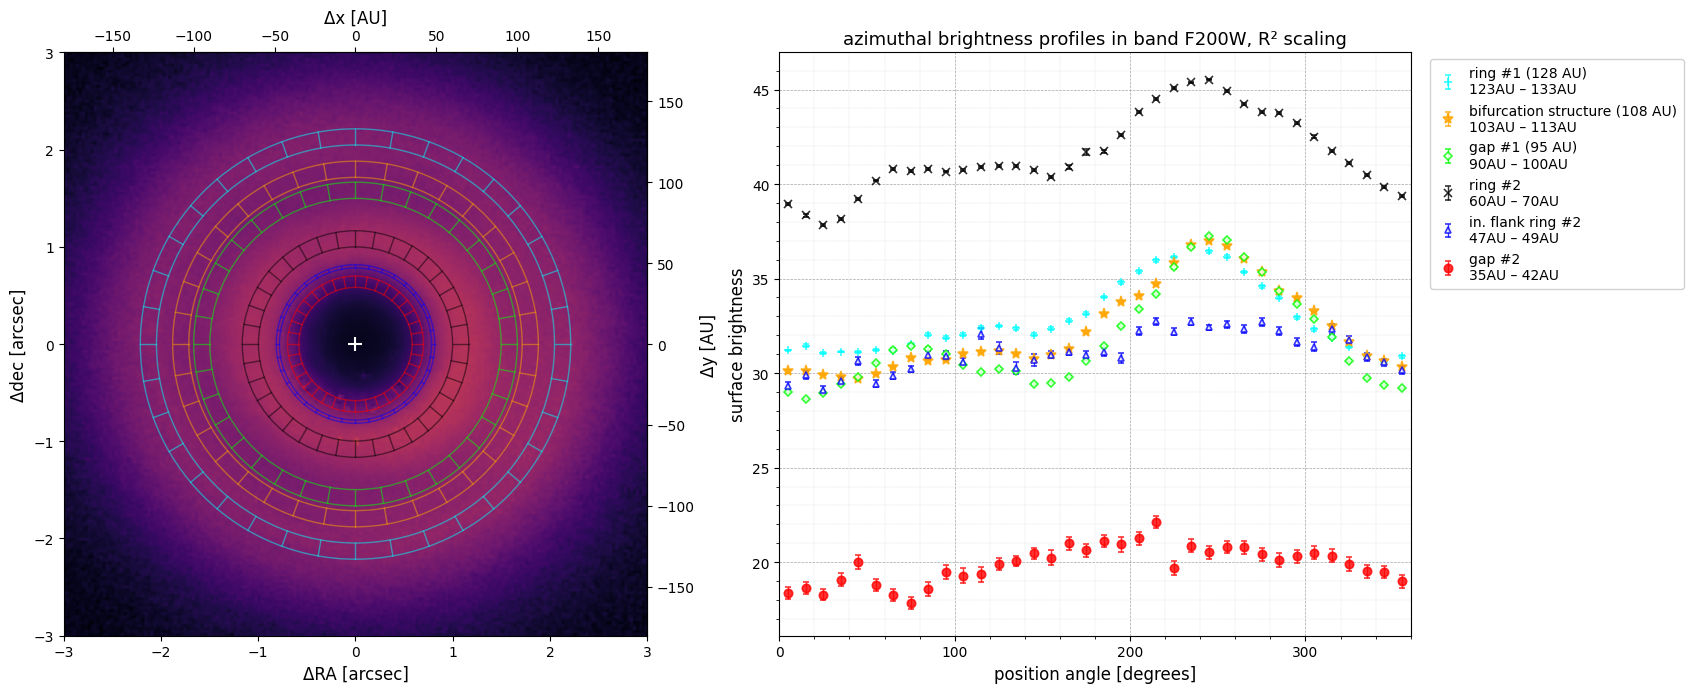

In [34]:
# --- Reproduce Figure 5 from the paper ---

# This cell reproduces the two-panel figure provided in the prompt.
# Left panel: The original image with overlays showing the annuli used for analysis.
# Right panel: The azimuthal brightness profiles for each annulus.

# --- Setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=100)
plt.subplots_adjust(wspace=0.3)
num_spokes = 36

# --- Left Plot: Image with Overlays ---

# distance of each pixel in arcseconds
distances = np.empty_like(cropped_image)
for i in range(cropped_image.shape[0]):
    for j in range(cropped_image.shape[1]):
        # Calculate distance from the center in arcseconds
        distances[i, j] = np.sqrt(((y_start + i) - center_y)**2 + ((x_start + j) - center_x)**2) * pixel_scale

ax1.imshow(cropped_image*distances**2, origin='lower', cmap='inferno', 
           vmax=100,
           extent=extent)

# Define regions from the right plot's legend in the paper
# Mark the regions we're analyzing with regions_check
markers = ['+', '*', 'D', 'x', '^', 'o']
size = [6, 8, 4, 6, 5, 6]  # Sizes for each marker
regions = {}
for i, (name, (r_in, r_out)) in enumerate(regions_check.items()):
    regions[name] = {
        'range': (r_in, r_out),
        'color': colors[i],
        'marker': markers[i],
        'size': size[i]
    }

# Draw the exact regions being analyzed in the right panel on the left image
# This ensures the overlays match the actual data being plotted
for name, props in regions.items():
    r_inner_au, r_outer_au = props['range']
    r_inner_arcsec = r_inner_au / dist
    r_outer_arcsec = r_outer_au / dist
    color = props['color']
    
    # Draw annulus boundaries for each region
    ring_inner = plt.Circle((0, 0), r_inner_arcsec, fill=False, color=color, 
                           linewidth=1, alpha=0.5, linestyle='-')
    ring_outer = plt.Circle((0, 0), r_outer_arcsec, fill=False, color=color, 
                           linewidth=1, alpha=0.5, linestyle='-')
    ax1.add_patch(ring_inner)
    ax1.add_patch(ring_outer)

    # Draw radial spokes ('spider') to show analysis zone
    for j in range(num_spokes):
        theta_spoke = 2 * np.pi * j / num_spokes
        x_inner = r_inner_arcsec * np.cos(theta_spoke)
        y_inner = r_inner_arcsec * np.sin(theta_spoke)
        x_outer = r_outer_arcsec * np.cos(theta_spoke)
        y_outer = r_outer_arcsec * np.sin(theta_spoke)
        ax1.plot([x_inner, x_outer], [y_inner, y_outer], color=color, linewidth=1, alpha=0.5)

    '''
    # Add a text label for each region
    short_label = name.replace(' (80 AU)', '').replace('in. flank ', '')
    mid_radius = (r_inner_arcsec + r_outer_arcsec) / 2
    angle_label = np.pi / 4  # 45 degrees
    label_x = mid_radius * np.cos(angle_label)
    label_y = mid_radius * np.sin(angle_label)
    ax1.text(label_x, label_y, short_label, color=color, fontsize=8, 
             fontweight='bold', ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    '''

# Add central star marker with a cross
ax1.plot(0, 0, marker='+', markersize=10, color='white', markeredgewidth=1.5, label='central star')

# Set up axes for the left plot
ax1.set_xlabel('ΔRA [arcsec]', fontsize=12)
ax1.set_ylabel('Δdec [arcsec]', fontsize=12)
ax1.set_xlim(extent[0], extent[1])
ax1.set_ylim(extent[2], extent[3])
ax1.set_aspect('equal', 'box')

# Add secondary axes in AU
secax_x = ax1.secondary_xaxis('top', functions=(lambda x: x * dist, lambda x: x / dist))
secax_x.set_xlabel('Δx [AU]', fontsize=12)
secax_y = ax1.secondary_yaxis('right', functions=(lambda y: y * dist, lambda y: y / dist))
secax_y.set_ylabel('Δy [AU]', fontsize=12)

# --- Right Plot: Azimuthal Brightness Profiles ----
# Create angle array
angles_deg = np.rad2deg(thetas)

# Plot each profile with proper styling
for name, props in list(regions.items()):
    r_inner_au, r_outer_au = props['range']
    
    # Convert AU to pixel radius
    r_inner_pix = (r_inner_au / dist) / pixel_scale
    r_outer_pix = (r_outer_au / dist) / pixel_scale
    
    # Find indices in radii_pix array
    idx_inner = np.argmin(np.abs(radii_pix - r_inner_pix))
    idx_outer = np.argmin(np.abs(radii_pix - r_outer_pix))
    
    if idx_inner >= idx_outer:
        continue

    # Extract annulus data
    annulus_data = polar_image_r2_scaled[:, idx_inner:idx_outer+1]
    
    # Build angular sections based on num_spokes
    angles_edges = np.linspace(0, 2 * np.pi, num_spokes + 1)
    angles_mid = (angles_edges[:-1] + angles_edges[1:]) / 2
    angles_deg_mid = np.rad2deg(angles_mid)

    # Compute section-wise mean and error
    profile = []
    yerr = []
    for j in range(num_spokes):
        # Mask angular slice
        mask_ang = (thetas >= angles_edges[j]) & (thetas < angles_edges[j+1])
        # Extract data for this segment and radial range
        seg_data = annulus_data[mask_ang, :].ravel()
        seg_data = seg_data[~np.isnan(seg_data)]
        if seg_data.size > 0:
            m = np.mean(seg_data)
            e = np.std(seg_data) / np.sqrt(seg_data.size)
        else:
            m, e = np.nan, np.nan
        profile.append(m)
        yerr.append(e)
    profile = np.array(profile)
    yerr = np.array(yerr)

    # Plot with segment-wise error bars
    ax2.errorbar(angles_deg_mid, profile, yerr=yerr,
                 fmt=props['marker'], markersize=props['size'], capsize=2,
                 color=props['color'], ecolor=props['color'], elinewidth=1,
                 markeredgecolor=props['color'],
                 markerfacecolor='white' if props['marker'] in ['D','s','^'] else props['color'],
                 label=f"{name}\n{r_inner_au}AU – {r_outer_au}AU", alpha=0.8,
                 linestyle='None', markeredgewidth=1.2)
    
    # Debug: Print brightness values for comparison
    mean_brightness = np.nanmean(profile)
    print(f"{name} ({r_inner_au}-{r_outer_au} AU): Mean brightness = {mean_brightness:.2e}")
    print(f"  - Radial range in pixels: {idx_inner} to {idx_outer}")
    print(f"  - Radial range in arcsec: {r_inner_arcsec:.3f} to {r_outer_arcsec:.3f}")
    
    # Also check the raw (unscaled) data for comparison
    annulus_data_raw = polar_image[:, idx_inner:idx_outer+1]
    raw_mean = np.nanmean(annulus_data_raw)
    print(f"  - Raw (no R²) mean brightness: {raw_mean:.2e}")
    print("---")

# Set up axes and styling to match the paper
ax2.set_title(f'azimuthal brightness profiles in band {filter_name}, R² scaling', fontsize=13)
ax2.set_xlabel('position angle [degrees]', fontsize=12)
ax2.set_ylabel('surface brightness', fontsize=12)
ax2.set_xlim(0, 360)
ax2.set_xticks([0, 100, 200, 300])
ax2.minorticks_on()
ax2.grid(which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax2.grid(which='minor', linestyle=':', linewidth=0.3, color='gray', alpha=0.5)

# Create legend positioned to not overlap with data
legend = ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
                   fontsize=10, handlelength=1.5, frameon=True, 
                   facecolor='white', framealpha=0.9, borderpad=0.5)

# --- Final Figure Adjustments ---

# Add figure caption
#fig.suptitle(f'Figure 1. Azimuthal intensity profiles in the {filter_name}-band, radially integrated over the gap and ring regions as indicated in the image.\nA distance of {dist:.1f} pc has been assumed.', 
#            fontsize=11, y=0.02, ha='center')

plt.tight_layout(rect=[0, 0.08, 0.85, 0.96])
plt.savefig('azimuthal.png', dpi=300, bbox_inches='tight')
plt.show()
